#  22961, mmn14

Author: Tal Glanzman

Date: 29/05/2024

[Notebook at Github](https://github.com/tglanz/bsc/blob/master/2024b-22961/mmn14/mmn14.ipynb)

[Youtube Link]()

In [1]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.cuda

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Sequence, Tuple, TypeVar

T = TypeVar('T')

### Q1

- Implementation of the `SplitLayer` class
- Neural block illustration
- Parameters size
- Gradient calculation

In [2]:
class SplitLayer(nn.Module):
    """ 
    An implementation of a neural network layer that given an input X it does the following:
    - Split X into two halves X1, X2
    - Feed X1, X2 into the same LinearLayer yielding outputs Z1, Z2
    - Feed Z1, Z2 into a ReLU layer yielding outputs Y1, Y2
    - Concatenate Y=[Y1, Y2]
    """

    # The number of input batches
    input_batches: int

    # The number of input features.
    # Because we split the input to two halves, this is expected to be even.
    input_features: int

    # Determines the size of each split.
    # It is basically input_features/2
    split_size: int

    # Determines the dimension to split by.
    # It is basically 1 since 1 is the expected features dimension.
    split_dim: int

    def __init__(self, input_batches: int, input_features: int):
        super().__init__()

        assert input_batches > 0, "expected input_batches to be positive"
        assert input_features % 2 == 0, "expected input_features to be even"

        self.input_batches = input_batches
        self.input_features = input_features

        self.split_dim = 1
        self.split_size = self.input_features // 2

        self.hidden = nn.Sequential(
            nn.Linear(self.split_size, self.split_size),
            nn.ReLU())

        self.initialize_weights()

    def initialize_weights(self):
        """
        Weight Initialization using Xavier's method.

        As explained here
        - https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization
        
        Xavier's method tackles the issue of exploding/vanishing gradients 
        """
        # sqrt(6 / (split_size + split_size))
        xavier = math.sqrt(3 / self.split_size) 

        with torch.no_grad():
            self.hidden[0].weight.uniform_(-xavier, +xavier)

        # Same as: (in fact I saw how to manually do it there)
        # torch.nn.init.uniform_(self.hidden[0].weight, -xavier, +xavier)

        # Bias is kept as is (0 bias)

    def forward(self, x: torch.Tensor, verbose=False):
        log = print if verbose else lambda x: ()

        log(f"  Input: {x}")

        a_in, b_in = x.split(split_size=self.split_size, dim=self.split_dim)
        log(f"  Split A: {a_in}")
        log(f"  Split B: {b_in}")

        a_out = self.hidden(a_in)
        log(f"  Ouput A: {a_in}")

        b_out = self.hidden(b_in)
        log(f"  Output B: {b_in}")

        y = torch.concat((a_out, b_out), dim=self.split_dim)
        log(f"  Output: {y}")

        return y

In [3]:
def demonstrate_split_layer():
    print("Demonstration of SplitLayer: ")
    
    x = torch.arange(12).reshape((3, 4)).float()
    
    split_layer = SplitLayer(3, 4)
    split_layer.train(False)
    
    split_layer.forward(x, verbose=True)

demonstrate_split_layer()

Demonstration of SplitLayer: 
  Input: tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])
  Split A: tensor([[0., 1.],
        [4., 5.],
        [8., 9.]])
  Split B: tensor([[ 2.,  3.],
        [ 6.,  7.],
        [10., 11.]])
  Ouput A: tensor([[0., 1.],
        [4., 5.],
        [8., 9.]])
  Output B: tensor([[ 2.,  3.],
        [ 6.,  7.],
        [10., 11.]])
  Output: tensor([[0.1983, 0.0000, 1.8729, 0.0000],
        [3.5475, 0.0000, 5.2220, 0.0000],
        [6.8966, 0.0000, 8.5712, 0.0000]], grad_fn=<CatBackward0>)


## SplitLayer illustration

![title](SplitLayer.png)

## Parameters size

A linear layer that maps an $n$ dimensional vector to an $m$ dimensional vector is a matrix of size $n \times m$ and a bias vector of size $m$.

Thus
- To map the original input $X$ of size $M$ we require $M^2 + M$ parameters.
- To map a splitted input of $X$ which is of size $\frac{M}{2}$ we require $\frac{M^2}{4} + \frac{M}{2}$ parameters

Because we feed both splits to the same layer, we use the same parameters and do not instantiate them twice.

To conclude, _SplitLayer_ uses (asymptotically) a quarter of the number of the parameters used by _LinearLayer_.

## Gradient Calculation for 2-split
We will use superscripts to denote the vectors as indicated by the illustration. For example $X^2$ is $X2$ in the diagram. We will use subscript to denote the specific element of the matrix/vector. For example, $X^2_{3,4}$ is the element at the 3rd row and the 4th column of the matrix $X^2$.

By definition of the _ReLU_ layer $ReLU(x) = \max \{x, 0 \}$, and because _ReLU_ is a scalar function we get the derivatives

$$
    \frac{\partial Y^i}{\partial Z^i} = \delta (Z^i)
$$

where $\delta$ is an elementwise function s.t $\delta(V) = [\delta(v_i)]$ and the scalar $\delta(v_i)$ is defined by

$$
\delta(v_i) = \begin{cases}
    1 & v_i > 0 \\
    0 & otherwise
\end{cases}
$$

By definition of the _Linear_ layer $Z = WX + b$ (Remember that $X$ and $Z$ are vectors)

$$
    Z_i = \sum_{k=1}W_{ik} X_k + b_i
$$

Hence,

$$
    \frac{\partial Z_i}{\partial W_{jk}} = \begin{cases}
        X_k & i = j \\
        0 & otherwise
    \end{cases}
    ~~~;~~~
    \frac{\partial Z_i}{\partial b_j} = \begin{cases}
        1 & i = j \\
        0 & otherwise
    \end{cases}
$$

By the chain rule

$$
    \frac{\partial C}{\partial W_{ij}} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \frac{\partial Y^1}{\partial Z^1} \cdot \frac{\partial Z^1}{\partial W_{ij}} \\
        \frac{\partial Y^2}{\partial Z^2} \cdot \frac{\partial Z^2}{\partial W_{ij}} \\
    \end{bmatrix} = 
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \delta(Z^1) \cdot \frac{\partial Z^1}{\partial W_{ij}} \\
        \delta(Z^2) \cdot \frac{\partial Z^2}{\partial W_{ij}} \\
    \end{bmatrix} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        0 \\
        \vdots \\
        0 \\
        \delta(Z^1_i) X^1_j \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^2_i) X^2_j \\
        0 \\
        \vdots \\
        0
    \end{bmatrix}
$$

Where the non-zero entries are the $i$ and the $\frac{m}{2} + i$ entries respectively.

Also by the chain rule

$$
    \frac{\partial C}{\partial b_{i}} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \frac{\partial Y^1}{\partial Z^1} \cdot \frac{\partial Z^1}{\partial b_i} \\
        \frac{\partial Y^2}{\partial Z^2} \cdot \frac{\partial Z^2}{\partial b_i} \\
    \end{bmatrix} = 
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \delta(Z^1) \cdot \frac{\partial Z^1}{\partial b_i} \\
        \delta(Z^2) \cdot \frac{\partial Z^2}{\partial b_i} \\
    \end{bmatrix} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        0 \\
        \vdots \\
        0 \\
        \delta(Z^1_i) \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^2_i) \\
        0 \\
        \vdots \\
        0
    \end{bmatrix}
$$

Where again the non-zero entries are the $i$ and the $\frac{m}{2} + i$ entries respectively.

## Extension of the Gradient for 4-split

The benefit of presenting the derivatives in vector form is that it is clearly generalized.

For an input the is split to 4 components $X_1, X_2, X_3$ and $X_4$ we get

$$
    \frac{\partial C}{\partial W_{ij}} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \frac{\partial Y^1}{\partial Z^1} \cdot \frac{\partial Z^1}{\partial W_{ij}} \\
        \frac{\partial Y^2}{\partial Z^2} \cdot \frac{\partial Z^2}{\partial W_{ij}} \\
    \end{bmatrix} = 
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \delta(Z^1) \cdot \frac{\partial Z^1}{\partial W_{ij}} \\
        \delta(Z^2) \cdot \frac{\partial Z^2}{\partial W_{ij}} \\
    \end{bmatrix} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        0 \\
        \vdots \\
        0 \\
        \delta(Z^1_i) X^1_j \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^2_i) X^2_j \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^3_i) X^3_j \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^4_i) X^4_j \\
        0 \\
        \vdots \\
        0
    \end{bmatrix}
~~~;~~~
    \frac{\partial C}{\partial b_{i}} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \frac{\partial Y^1}{\partial Z^1} \cdot \frac{\partial Z^1}{\partial b_i} \\
        \frac{\partial Y^2}{\partial Z^2} \cdot \frac{\partial Z^2}{\partial b_i} \\
    \end{bmatrix} = 
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        \delta(Z^1) \cdot \frac{\partial Z^1}{\partial b_i} \\
        \delta(Z^2) \cdot \frac{\partial Z^2}{\partial b_i} \\
    \end{bmatrix} =
    \frac{\partial C}{\partial Y} \begin{bmatrix}
        0 \\
        \vdots \\
        0 \\
        \delta(Z^1_i) \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^2_i) \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^3_i) \\
        0 \\
        \vdots \\
        0 \\
        \delta(Z^4_i) \\
        0 \\
        \vdots \\
        0
    \end{bmatrix}
$$

# Q2

In [11]:
class DropNorm(nn.Module):
    """
    The DropNorm module drops **exactly** half of the neurons and normalizes through scaling and translation.

    Each active neuron is rescaled according to its mean and variance. Then, it is re-adjusted using the learned
    parameters gamma and beta. i.e., given a neuron x, the output y is given by

        z = (x - E(x)) / sqrt(Var(x) + Epsilon)
        y = gamma * z + beta

    In order not to recompute the mean and variance at inference time,  the module keeps a weighted average 
    """

    def __init__(self,
                 in_features: torch.Size,
                 device: Optional[torch.device] = None,
                 epsilon: float = 10e-5,
                 mu_avg_coeff: float = 0.9,
                 sigma2_avg_coeff: float = 0.9):
        """

        Parameters
          input_shape {torch.Size} indicates the shape of the inputs. The first dimension is the batch size.

          device {Optional[torch.device]} The device to allocate the block's tensors and run computations on.
            If no device has been specified, tries to allocate on cuda, otherwise cpu.

          epsilon {float} Used to avoid zero division.
            According to the chapter on Normalization layers (bullet 1), it is usually 10e-5.

          mu_avg_coeff {float} An hyperparameter determining the mean's average weight. The average mean is calculated as
            average_mean = coeff*previous_average_mean + (1-coeff)*current_mean
        
          sigma2_avg_coeff {float} An hyperparameter determining the variances's average weight. Calculation is done like the average mean.
        """
        super().__init__()

        assert in_features.numel() % 2 == 0, "Expected number of elements to be even"

        self.epsilon = epsilon
        self.in_features = in_features

        if device is None:
            if torch.cuda.is_available():
                device = torch.device("cuda:0")
            else:
                device = torch.device("cpu")
        self.device = device

        # According to the chapter on Normalization layers (bullet 2), the input might not be best kept normalized.
        # So, we want to learn the parameters (beta and gamma) to translate and scale them 
        self.gamma = nn.Parameter(torch.ones(in_features, device=device))
        self.beta = nn.Parameter(torch.zeros(in_features, device=device))

        # As taught, it is beneficial to keep track of the averages of the mean and variances to use in inference time. 
        self.mu_avg_coeff = mu_avg_coeff
        self.mu_avg = torch.zeros(in_features, device=device)
        self.sigma2_avg_coeff = sigma2_avg_coeff
        self.sigma2_avg = torch.ones(in_features, device=device)

    def create_features_mask(self) -> torch.Tensor:
        """
        Create a mask tensor containing False/True values
        indicating which neurons are active (True positions) and which are not (False positions).

        Because we asked to deactivate **exactly** half of the neurons, we couldn't use and probabilistic method
        such as randomizing a number in [0,1) and taking those that are larger than 0.5.

        We implemented this by concatenating two, equal sized tensors of ones and zeros and then shuffling them.
        Each one is mapped to True, each 0 is mapped to False.

        Returns
          A boolean `torch.Tensor` of shape `self.in_features`
        """
        zeros_count = self.in_features.numel() // 2
        ones_count = zeros_count
        mask = torch.concat((
            torch.zeros(zeros_count, device=self.device),
            torch.ones(ones_count, device=self.device)))
        mask = mask[torch.randperm(mask.numel())]
        mask = mask.reshape(self.in_features)
        return mask == 1

    def forward(self, x: torch.Tensor):
        x.to(device=self.device)
        
        mask = self.create_features_mask()
        sub_x = x[:, mask]

        if self.training:
            # If training mode, we want to update the average mean and variance
            sigma2, mu = torch.var_mean(sub_x, dim=0)

            with torch.no_grad():
                self.mu_avg[mask] = self.mu_avg_coeff * self.mu_avg[mask] + (1 - self.mu_avg_coeff) * mu
                self.sigma2_avg[mask] = self.sigma2_avg_coeff * self.sigma2_avg[mask] + (1 - self.sigma2_avg_coeff) * sigma2
        else:
            # If not training mode, we want to recall the average mean and variance we adjusted during training mode
            sigma2 = self.sigma2_avg[mask]
            mu = self.mu_avg[mask]

        # calculate the output
        x_hat = torch.zeros(x.shape, device=self.device)
        x_hat[:, mask] = (sub_x.flatten(1) - mu.unsqueeze(0)) / torch.sqrt(sigma2.unsqueeze(0) + self.epsilon)
        y = self.gamma * x_hat + self.beta
        
        return y

def get_fashion_mnist_datasets(location: str = "./datasets") -> Tuple[Dataset, Dataset]:
    """
    Load the FashionMNIST dataset and apply the relevant transformations

    Parameters
        location {str} Determines where to download the datasets to in the case they havn't been downloaded yet

    Returns
        A Tuple[Dataset, Dataset] containing the training dataset (first element) and the test dataset (second element)
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float),
        torchvision.transforms.Lambda(torch.flatten)
    ])

    train_ds = torchvision.datasets.FashionMNIST(location, train=True, download=True, transform=transform)
    test_ds = torchvision.datasets.FashionMNIST(location, train=False, download=True, transform=transform)

    return train_ds, test_ds

def train_model(
        model: nn.Module,
        train_dl: DataLoader,
        epochs: int,
        batch_limit: Optional[int] = None
) -> Sequence[float]:
    """
    Trains a given model using the data provided through the given DataLoader.

    Parameters
        model {nn.Module} The model to train

        train_dl {DataLoader} A DataLoader providing the training samples

        epochs {int} Determines how many epochs to run the training

        batch_limit {int} Determins a limit on how many batches to train on at each epoch.
                          This is used mainly for debuggin purposes to shorten the training times.
    """
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    accuracy_per_epoch = [0] * epochs

    batches = len(train_dl)

    model.train(True)
    for epoch in range(epochs):
        for batch, (xs, ys) in enumerate(train_dl):

            if batch_limit is not None and batch > batch_limit:
                break

            optimizer.zero_grad()
            ys_model = model.forward(xs)
            loss = loss_fn(ys_model, ys)
            loss.backward()

            # track accuracies
            inferred_classes = torch.argmax(ys_model, dim=1)
            accuracy = (inferred_classes == ys).sum() / len(ys)
            accuracy_per_epoch[epoch] += accuracy.item()

            optimizer.step()
        
        accuracy_per_epoch[epoch] /= len(train_dl)
        scheduler.step(accuracy_per_epoch[epoch])
        print(f"Epoch {epoch} has a mean accuracy of {accuracy_per_epoch[epoch] * 100:.2f}%")

    return accuracy_per_epoch

def eval_model(model: nn.Module, test_dl: DataLoader) -> Tuple[float, float]:
    """
    Evaluates a given model.
    
    Parameters
        test_dl {DataLoader} The samples to evaluate the model against.

    Returns
        A Tuple of (variance, mean) of the accuracies of the model accross each loaded batch.
    """
    batches = len(test_dl)
    accuracy_per_batch = [0] * batches

    model.eval()
    for batch, (xs, ys) in enumerate(test_dl):
        ys_model = model.forward(xs)

        inferred_classes = torch.argmax(ys_model, dim=1)
        accuracy = (inferred_classes == ys).sum() / len(ys)
        accuracy_per_batch[batch] = accuracy

    sigma2, mu = torch.var_mean(torch.tensor(accuracy_per_batch))
    return sigma2, mu

def normal_density_function(tensor: torch.Tensor, sigma: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
    """ Computes the normal density function with parameters `sigma` and `mu` """
    a = sigma.mul(math.sqrt(2 * math.pi))
    b = torch.pow(((tensor - mu)/sigma), 2).mul(-1/2)
    return tensor.div(a).mul(torch.exp(b))

def plot_model_stats(
        model_name: str,
        eval_normal_distribution: Tuple[torch.Tensor, torch.Tensor],
        train_accuracy_per_epoch: Sequence[float]):
    """ Plots the statistics we gathered on a given model """    
    sigma2, mu = eval_normal_distribution
    
    fig = plt.figure()
    fig.suptitle(f"Model Stats: {model_name}. Mean accuracy {mu * 100:.0f}%")

    ax = plt.subplot(1, 2, 1)
    plt.plot([acc * 100 for acc in train_accuracy_per_epoch])
    ax = fig.axes[0]
    ax.set_title("Training accuracies")
    ax.set_xlabel("Epoch")
    xticks = list(range(len(train_accuracy_per_epoch)))
    ax.set_ylabel("Accuracy (%)")

    ax = plt.subplot(1, 2, 2)
    sigma = sigma2.sqrt()
    # bell_x = torch.linspace(mu - 6 * sigma, mu + 6 * sigma, 100)
    bell_x = torch.linspace(0, 1, 100)
    bell_y = normal_density_function(bell_x, sigma, mu)
    ax.set_title(f"Batch accuracy distribution")
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Density")
    plt.vlines([mu - 3 * sigma, mu + 3 * sigma], bell_y.min(), bell_y.max(), colors="r", linestyles="dotted")
    plt.plot(bell_x.numpy(), bell_y.numpy())

def train_and_evaluate_model(model_name: str, train_dl: DataLoader, test_dl: DataLoader, model: nn.Module):
    print(f"Training model \"{model_name}\"")
    train_accuracy_per_epoch = train_model(model, train_dl, 7, batch_limit=None)
    eval_normal_distribution = eval_model(model, test_dl)
    print(f"{model_name} has reached mean accuracy of {eval_normal_distribution[1] * 100:.0f}%")
    plot_model_stats(model_name, eval_normal_distribution, train_accuracy_per_epoch)
    print()

In [9]:
train_ds, test_ds = get_fashion_mnist_datasets()
train_dl = DataLoader(train_ds, batch_size=256)
test_dl = DataLoader(test_ds, batch_size=256)

in_features = next(iter(train_dl))[0][0].shape[0]
out_features = len(train_ds.classes)

Training model "Model A"
Epoch 0 has a mean accuracy of 79.63%
Epoch 1 has a mean accuracy of 83.23%
Epoch 2 has a mean accuracy of 83.76%
Epoch 3 has a mean accuracy of 84.15%
Epoch 4 has a mean accuracy of 84.52%
Epoch 5 has a mean accuracy of 84.64%
Epoch 6 has a mean accuracy of 84.75%
Model A has reached mean accuracy of 84%



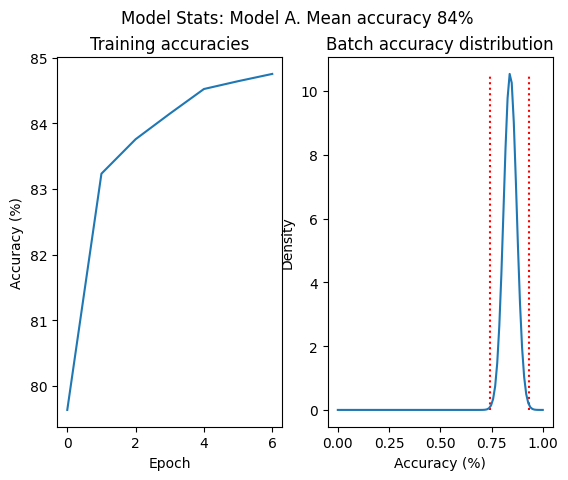

In [12]:
train_and_evaluate_model("Model A", train_dl, test_dl, nn.Sequential(
    nn.Linear(in_features=in_features, out_features=in_features // 2),
    nn.BatchNorm1d(in_features // 2),
    nn.Dropout(),
    nn.Linear(in_features=in_features // 2, out_features=out_features),
    nn.LogSoftmax(dim=1),
))

Training model "Model B"
Epoch 0 has a mean accuracy of 78.19%
Epoch 1 has a mean accuracy of 83.03%
Epoch 2 has a mean accuracy of 83.89%
Epoch 3 has a mean accuracy of 84.08%
Epoch 4 has a mean accuracy of 84.47%
Epoch 5 has a mean accuracy of 84.71%
Epoch 6 has a mean accuracy of 84.81%
Model B has reached mean accuracy of 83%



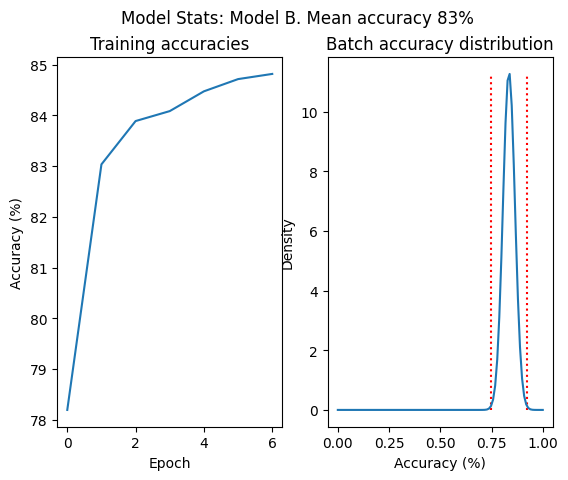

In [13]:
train_and_evaluate_model("Model B", train_dl, test_dl, nn.Sequential(
    nn.Linear(in_features=in_features, out_features=in_features // 2),
    DropNorm(in_features=torch.Size([in_features // 2])),
    nn.Linear(in_features=in_features // 2, out_features=out_features),
    nn.LogSoftmax(dim=1),
))

## Comparison of Model A vs. Model B

Accuracy wise, they perform roughly the same. They have reached the same final mean accuracy, the variance looks the same and the slope of which the accuracy risen also looks the same (i.e. the training speed is roughly the same).

Computationally wise, Model B with the use of the `DropNorm` layer, normalizes only half the neurons each pass of the network so in this aspect it is preferable.

To conclude, for the reasons above, I would choose Model B for this task.